In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute  import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics


ocross = pd.read_csv("./oasis_cross-sectional.csv")
olong = pd.read_csv("./oasis_longitudinal.csv")

# print(ocross.head(1))
# print(olong.head(1))

print(ocross.info())
print(olong.info())

print("Highest age is ", np.max([np.max(ocross.Age), np.max(olong.Age)]), "and lowest age is ", np.min([np.min(ocross.Age), np.min(olong.Age)]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

In [137]:
print(olong[olong["Group"] == "Demented"]["CDR"].unique())
print(olong[olong["Group"] == "Nondemented"]["CDR"].unique())
print(olong[olong["Group"] == "Converted"]["CDR"].unique())


[0.5 1.  2. ]
[0.  0.5]
[0.  0.5]


In [138]:
group_map = {0:"Nondemented", 1:"Demented", 2:"Demented"}
ocross['Group'] = ocross['CDR'].map(group_map)

ocross.Group.value_counts()

Nondemented    135
Demented        30
Name: Group, dtype: int64

In [139]:
ocross.dropna(subset=['Group'],inplace=True)
ocross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 415
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      165 non-null    object 
 1   M/F     165 non-null    object 
 2   Hand    165 non-null    object 
 3   Age     165 non-null    int64  
 4   Educ    165 non-null    float64
 5   SES     159 non-null    float64
 6   MMSE    165 non-null    float64
 7   CDR     165 non-null    float64
 8   eTIV    165 non-null    int64  
 9   nWBV    165 non-null    float64
 10  ASF     165 non-null    float64
 11  Delay   0 non-null      float64
 12  Group   165 non-null    object 
dtypes: float64(7), int64(2), object(4)
memory usage: 18.0+ KB


In [140]:
ocross.drop(columns=['ID','Delay'],inplace=True)

olong = olong.rename(columns={'EDUC':'Educ'})
olong.drop(columns=['Subject ID','MRI ID','Visit','MR Delay'],inplace=True)

data = pd.concat([ocross,olong])
data.rename(columns={"M/F" : "Gender"}, inplace=True)
# reset data index
data = data.reset_index()

print(data.head(1))
data.info()

   index Gender Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0      0      F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   

         Group  
0  Nondemented  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   538 non-null    int64  
 1   Gender  538 non-null    object 
 2   Hand    538 non-null    object 
 3   Age     538 non-null    int64  
 4   Educ    538 non-null    float64
 5   SES     513 non-null    float64
 6   MMSE    536 non-null    float64
 7   CDR     538 non-null    float64
 8   eTIV    538 non-null    int64  
 9   nWBV    538 non-null    float64
 10  ASF     538 non-null    float64
 11  Group   538 non-null    object 
dtypes: float64(6), int64(3), object(3)
memory usage: 50.6+ KB


In [141]:
print(data.Hand.value_counts())


R    538
Name: Hand, dtype: int64


In [142]:
data.Group.value_counts()

Nondemented    325
Demented       176
Converted       37
Name: Group, dtype: int64

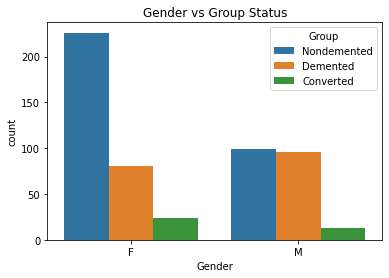

In [143]:
working = data

sns.countplot(x="Gender", data=working, hue="Group")
plt.title("Gender vs Group Status")
plt.show()

<AxesSubplot:xlabel='Group', ylabel='CDR'>

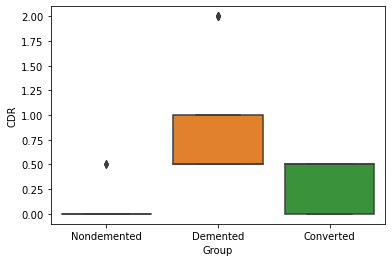

In [144]:
sns.boxplot(x='Group', y="CDR", data=working)

In [145]:
# imputing wth the most occurrance
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# imputing with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   538 non-null    int64  
 1   Gender  538 non-null    object 
 2   Hand    538 non-null    object 
 3   Age     538 non-null    int64  
 4   Educ    538 non-null    float64
 5   SES     538 non-null    float64
 6   MMSE    538 non-null    float64
 7   CDR     538 non-null    float64
 8   eTIV    538 non-null    int64  
 9   nWBV    538 non-null    float64
 10  ASF     538 non-null    float64
 11  Group   538 non-null    object 
dtypes: float64(6), int64(3), object(3)
memory usage: 50.6+ KB


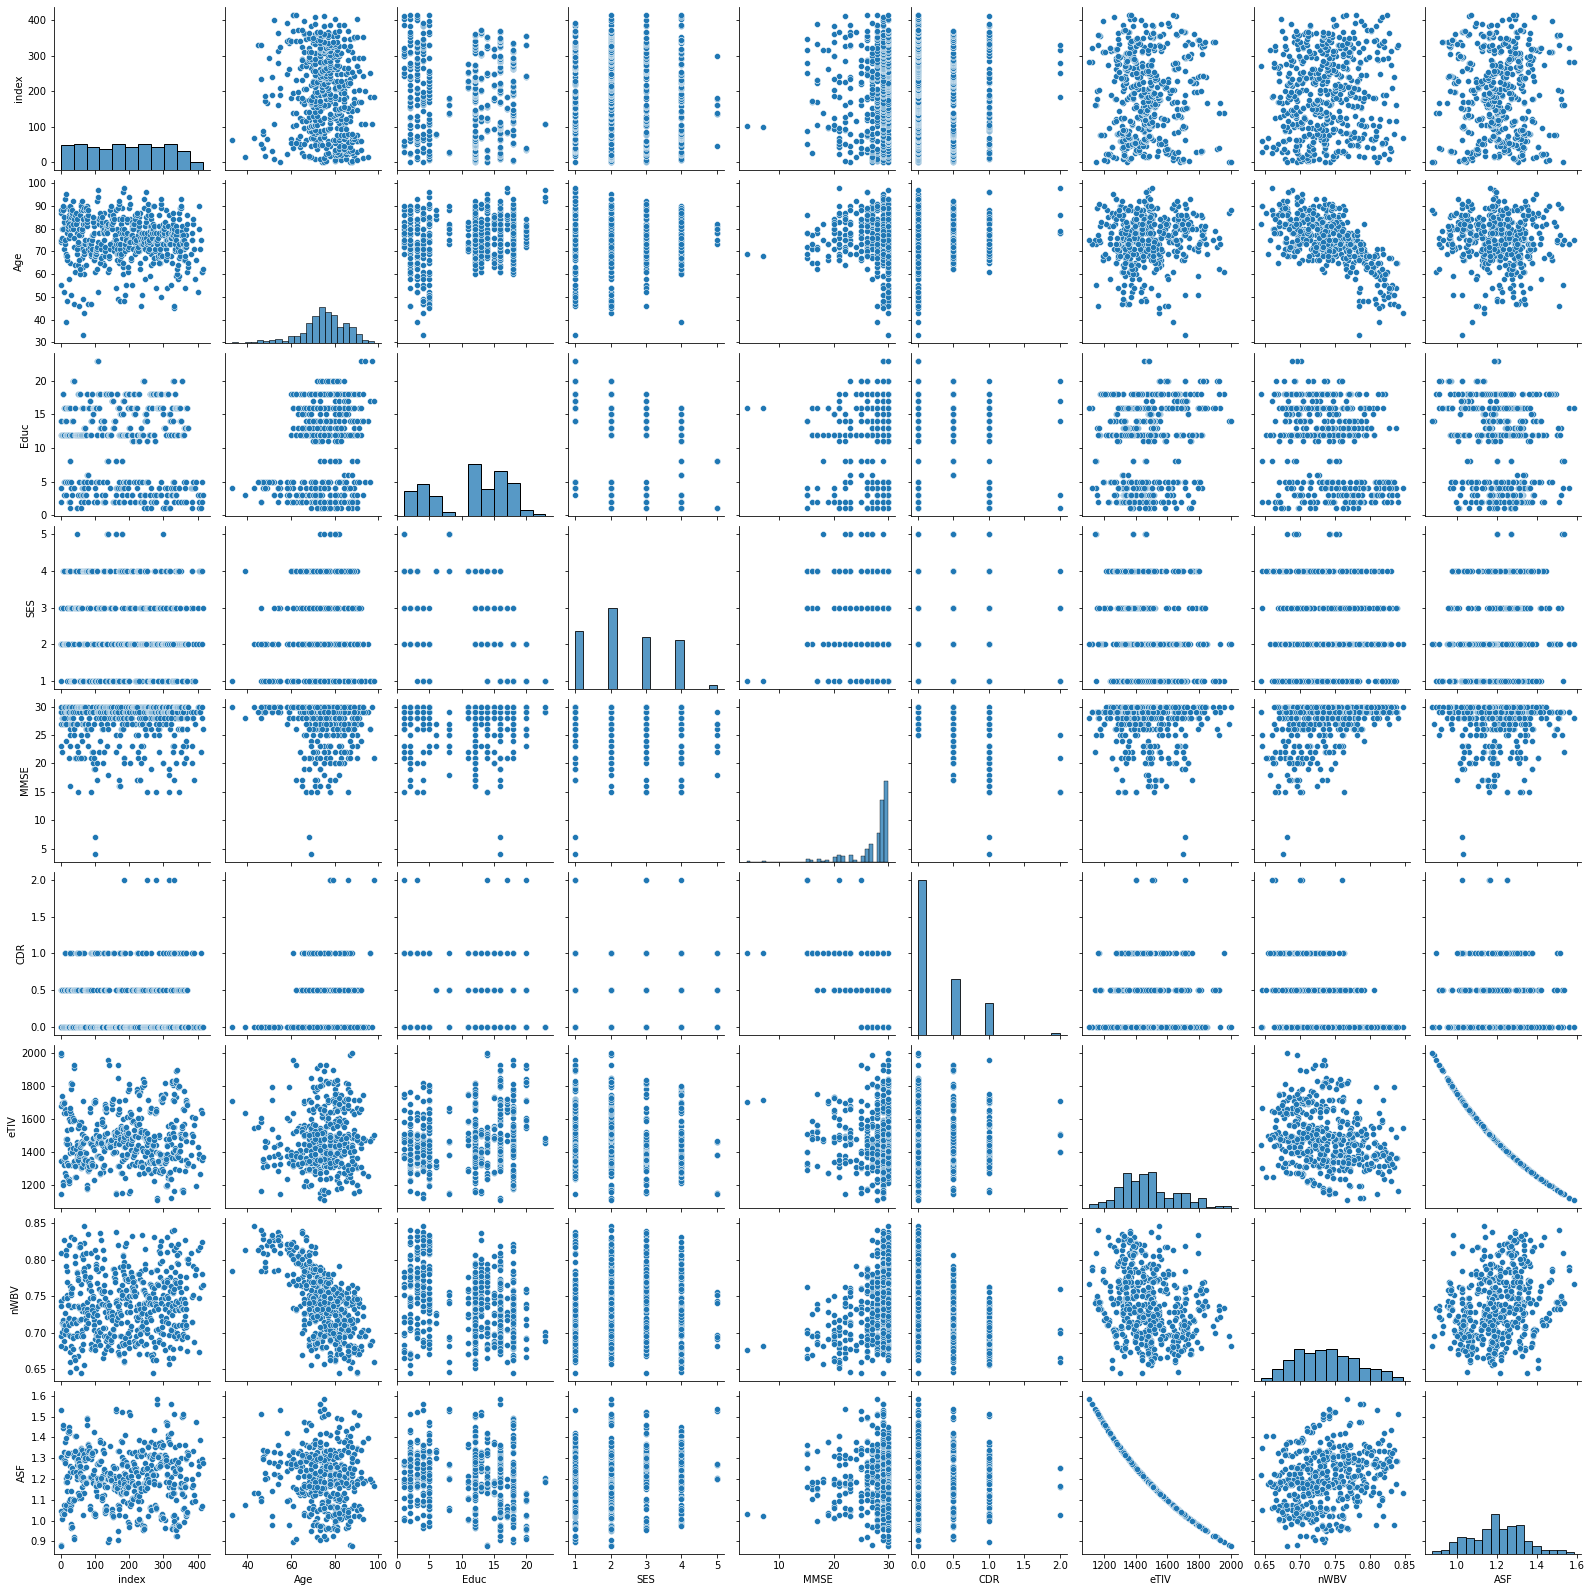

In [146]:
# using pairplot to visualise each feature against every other feature
sns.pairplot(data)

In [147]:
# converting categorical features to numerical values

data["Gender"] = np.where(data["Gender"] == 'F', 1, 0)
data["Hand"] = np.where(data["Hand"] == 'R', 1, 0)
data["Group"] = np.where(data["Group"] == 'Demented', 1, 0)

<AxesSubplot:>

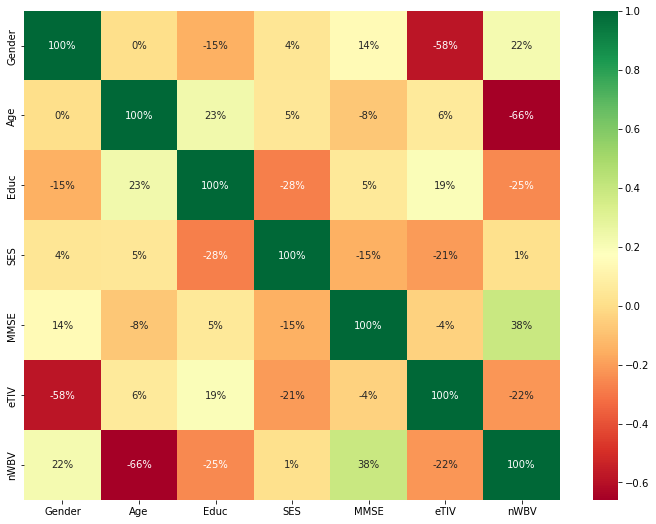

In [155]:

cor = data.corr()
plt.figure(figsize=(12,9))
# checking if the features are correlated or not using seaborn heatmap
sns.heatmap(cor, xticklabels=cor.columns.values, yticklabels=cor.columns.values, annot=True, fmt=".0%", cmap="RdYlGn")

In [149]:
# dropping extra features
data.drop(columns=["Hand", "CDR", "ASF"], inplace=True)

In [150]:
# import pandas_profiling as pp
# pp.ProfileReport(data)

In [151]:
# dividing data into descriptive and target features
y = data.pop('Group')
data.pop("index")
x = data

# since the ranges of the descriptive features are different we normalize them


x = StandardScaler().fit_transform(x)

In [152]:
# spliting the data into test and train datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0,test_size=0.2)

In [166]:

model = LogisticRegression()
model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()


model.fit(x_train, y_train)
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)


GradientBoostingClassifier()

In [167]:
print(model,"->", "{:.0%}".format(model.score(x_test, y_test)))
print(model1,"->", "{:.0%}".format(model1.score(x_test, y_test)))
print(model2,"->", "{:.0%}".format(model2.score(x_test, y_test)))

pred = model.predict(x_test)

# comp = pd.DataFrame({"Real": y_test, "Predicted": pred})
# print(comp)

LogisticRegression() -> 93%
RandomForestClassifier() -> 94%
GradientBoostingClassifier() -> 93%


In [ ]:
# The best is RandomForestClassifier